- LCC
- Image Preprocessing
    - Breast Cropping
    - 224 x 224 pixels
    - Data Augmentation (Random Horizontal Flip)
- Balanced datasets with around 6000 of each classes

In [1]:
import tensorflow as tf
print(tf.config.list_physical_devices('GPU'))

2025-02-18 12:07:23.186619: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-02-18 12:07:23.654490: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]


2025-02-18 12:07:24.383447: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-02-18 12:07:24.383800: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-02-18 12:07:24.407815: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [2]:
import os
import pandas as pd
import random
import matplotlib.pyplot as plt
from pydicom import dcmread
from pydicom.errors import InvalidDicomError
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
from sklearn.utils.class_weight import compute_class_weight
from sklearn.utils import resample
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB3
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Input, Conv2D, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import Model
from collections import Counter
import numpy as np
import cv2

In [3]:
# Load the original dataset for training
csv_path = '/home/yu-tingtseng_sa/GitHub/AI-ethnicity-med-image/data/Mammo/All_XWalk_Outcome_cleaned.csv'
data = pd.read_csv(csv_path, sep=',', quotechar='"', low_memory=False)

# Define base paths for both datasets
correct_base_path_train = "/media/yu-tingtseng_sa/Data1"
correct_base_path_test = "/mnt/data2"

# Standardize file paths in training dataset
data['FilePath'] = data['FilePath'].str.replace(r"^Q:\\", correct_base_path_train + "/", regex=True)
data['FilePath'] = data['FilePath'].str.replace(r"\\\\|\\", "/", regex=True)  # Convert backslashes

# Remove rows with invalid or missing FilePath
data = data.dropna(subset=['FilePath'])
data = data[data['FilePath'].apply(lambda x: isinstance(x, str))]

# Ethnicity mapping function
def map_ethnicity(ethnicity):
    mapping = {
        "BR": "White", "EE": "White", "FR": "White", "NE": "White", "SE": "White", "WE": "White",
        "EA": "Asian - East and Southeast",
        "SA": "Asian - South"
    }
    return mapping.get(ethnicity, "Other")

data['ethnicity'] = data['ethnicity'].apply(map_ethnicity)

# Filter for selected ethnicities
data = data[data['ethnicity'].isin(["White", "Asian - East and Southeast", "Asian - South"])]

In [4]:
# Stratified sampling: Select 4500 images per ethnicity for training
target_per_class_train = 4500
stratified_train_samples = []

for ethnicity, group in data.groupby('ethnicity'):
    stratified_train_samples.append(group.sample(
        n=min(target_per_class_train, len(group)),
        random_state=42
    ))

data_train = pd.concat(stratified_train_samples, ignore_index=True)

# Load the new test dataset
new_csv_path = '/home/yu-tingtseng_sa/GitHub/AI-ethnicity-med-image/data/Mammo/D1-D4_matched_v1.csv'
data_test = pd.read_csv(new_csv_path, sep=',', quotechar='"', low_memory=False)

# Standardize file paths in test dataset (located in /mnt/data2)
data_test['FilePath'] = data_test['FilePath'].str.replace(r"^Q:\\", correct_base_path_test + "/", regex=True)
data_test['FilePath'] = data_test['FilePath'].str.replace(r"\\\\|\\", "/", regex=True)

# Remove invalid/missing FilePath
data_test = data_test.dropna(subset=['FilePath'])
data_test = data_test[data_test['FilePath'].apply(lambda x: isinstance(x, str))]

# Apply ethnicity mapping
data_test['ethnicity'] = data_test['ethnicity'].apply(map_ethnicity)

# Filter for selected ethnicities
data_test = data_test[data_test['ethnicity'].isin(["White", "Asian - East and Southeast", "Asian - South"])]

# Stratified sampling: Select 1500 images per ethnicity for testing
target_per_class_test = 1500
stratified_test_samples = []

for ethnicity, group in data_test.groupby('ethnicity'):
    stratified_test_samples.append(group.sample(
        n=min(target_per_class_test, len(group)),
        random_state=42
    ))

data_test = pd.concat(stratified_test_samples, ignore_index=True)

In [6]:
# Print ethnicity distribution 
print("Train Dataset Ethnicity Distribution:") 
print(data_train['ethnicity'].value_counts()) 
print("\nTest Dataset Ethnicity Distribution:") 
print(data_test['ethnicity'].value_counts()) 

'''
# Plot ethnicity distribution for train dataset
plt.figure(figsize=(8, 4)) 
plt.bar(data_train['ethnicity'].value_counts().index, data_train['ethnicity'].value_counts().values) 
plt.xlabel("Ethnicity") 
plt.ylabel("Count") 
plt.title("Train Dataset Ethnicity Distribution") 
plt.xticks(rotation=45) 
plt.show() 

# Plot ethnicity distribution for test dataset 
plt.figure(figsize=(8, 4)) 
plt.bar(data_test['ethnicity'].value_counts().index, data_test['ethnicity'].value_counts().values) 
plt.xlabel("Ethnicity") 
plt.ylabel("Count") 
plt.title("Test Dataset Ethnicity Distribution") 
plt.xticks(rotation=45) 
plt.show()
'''

Train Dataset Ethnicity Distribution:
ethnicity
Asian - East and Southeast    4500
Asian - South                 4500
White                         4500
Name: count, dtype: int64

Test Dataset Ethnicity Distribution:
ethnicity
Asian - East and Southeast    1500
Asian - South                 1500
White                         1500
Name: count, dtype: int64


'\n# Plot ethnicity distribution for train dataset\nplt.figure(figsize=(8, 4)) \nplt.bar(data_train[\'ethnicity\'].value_counts().index, data_train[\'ethnicity\'].value_counts().values) \nplt.xlabel("Ethnicity") \nplt.ylabel("Count") \nplt.title("Train Dataset Ethnicity Distribution") \nplt.xticks(rotation=45) \nplt.show() \n\n# Plot ethnicity distribution for test dataset \nplt.figure(figsize=(8, 4)) \nplt.bar(data_test[\'ethnicity\'].value_counts().index, data_test[\'ethnicity\'].value_counts().values) \nplt.xlabel("Ethnicity") \nplt.ylabel("Count") \nplt.title("Test Dataset Ethnicity Distribution") \nplt.xticks(rotation=45) \nplt.show()\n'

In [7]:
# Image preprocessing function (SAME METHOD AS BEFORE)
def preprocess(pngPath, output_dir):
    img = cv2.imread(pngPath, cv2.IMREAD_GRAYSCALE)

    # Create a binary image for the breast
    binary_img = cv2.threshold(img, 1, 255, cv2.THRESH_BINARY)[1].astype(np.uint8)

    # Find contours
    contours, _ = cv2.findContours(binary_img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if not contours:
        raise ValueError("No contours found.")
    largest_contour = max(contours, key=cv2.contourArea)

    # Create a mask for the breast region
    mask = np.zeros(img.shape, np.uint8)
    mask = cv2.fillPoly(mask, [largest_contour], 255)

    # Find bounding box
    x, y, w, h = cv2.boundingRect(largest_contour)

    # Crop the image
    imgCropped = img[y:y+h, x:x+w]

    # Make the cropped image square by padding
    max_dim = max(w, h)
    padded_img = cv2.copyMakeBorder(
        imgCropped,
        top=(max_dim - h) // 2,
        bottom=(max_dim - h + 1) // 2,
        left=(max_dim - w) // 2,
        right=(max_dim - w + 1) // 2,
        borderType=cv2.BORDER_CONSTANT,
        value=0  # Black background
    )

    # Save the processed image in a structured folder (SAME AS BEFORE)
    patient_dir = os.path.dirname(pngPath).replace("/", "_").replace("\\", "_")
    patient_output_dir = os.path.join(output_dir, patient_dir)
    os.makedirs(patient_output_dir, exist_ok=True)
    output_path = os.path.join(patient_output_dir, os.path.basename(pngPath))
    
    cv2.imwrite(output_path, padded_img)
    
    return output_path

In [ ]:
# Output directory for images
output_dir = "/tmp/e3/processed_images"

# Function to prepare LCC-only images (SAME METHOD)
def prepare_lcc_data(data, output_dir):
    filepaths = []
    labels = []

    for folder_path in data['FilePath']:
        if os.path.exists(folder_path):
            all_files = [os.path.join(folder_path, f) for f in os.listdir(folder_path) if f.endswith('.png')]
            lcc_files = [f for f in all_files if "LCC" in f]
            if lcc_files:
                try:
                    lcc_cropped_path = preprocess(lcc_files[0], output_dir)
                    filepaths.append(lcc_cropped_path)
                    patient_id = os.path.basename(os.path.dirname(folder_path))
                    matching_rows = data[data['patient_id'] == patient_id]
                    if matching_rows.empty:
                        print(f"Warning: No matching label found for patient_id {patient_id}. Skipping.")
                        continue
                    label = matching_rows['ethnicity'].iloc[0]
                    labels.append(label)
                except Exception as e:
                    print(f"Error processing {folder_path}: {e}")

    return filepaths, labels

# Prepare training and test datasets
train_lcc_filepaths, train_lcc_labels = prepare_lcc_data(data_train, output_dir)
test_lcc_filepaths, test_lcc_labels = prepare_lcc_data(data_test, output_dir)

In [8]:
# Convert LCC labels to numeric format
def encode_labels(labels):
    label_mapping = {label: idx for idx, label in enumerate(set(labels))}
    encoded_labels = [label_mapping[label] for label in labels]
    return encoded_labels, label_mapping

encoded_train_lcc_labels, lcc_label_mapping = encode_labels(train_lcc_labels)
encoded_test_lcc_labels = [lcc_label_mapping[label] for label in test_lcc_labels]

# Create TensorFlow datasets
def create_lcc_dataset(filepaths, labels, augment=False):
    def load_lcc_image(filepath, label):
        image = tf.image.decode_png(tf.io.read_file(filepath), channels=1)
        image = tf.image.resize(image, [512, 512])

        if augment:
            image = tf.image.random_flip_left_right(image)

        return tf.cast(image, tf.float32) / 255.0, label

    dataset = tf.data.Dataset.from_tensor_slices((filepaths, labels))
    dataset = dataset.map(
        lambda filepath, label: load_lcc_image(filepath, label),
        num_parallel_calls=tf.data.AUTOTUNE
    )

    return dataset

train_lcc_dataset = create_lcc_dataset(train_lcc_filepaths, encoded_train_lcc_labels, augment=True).batch(16).prefetch(tf.data.AUTOTUNE)
test_lcc_dataset = create_lcc_dataset(test_lcc_filepaths, encoded_test_lcc_labels, augment=False).batch(16).prefetch(tf.data.AUTOTUNE)


2025-02-18 09:29:00.055557: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-02-18 09:29:00.055761: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-02-18 09:29:00.055934: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

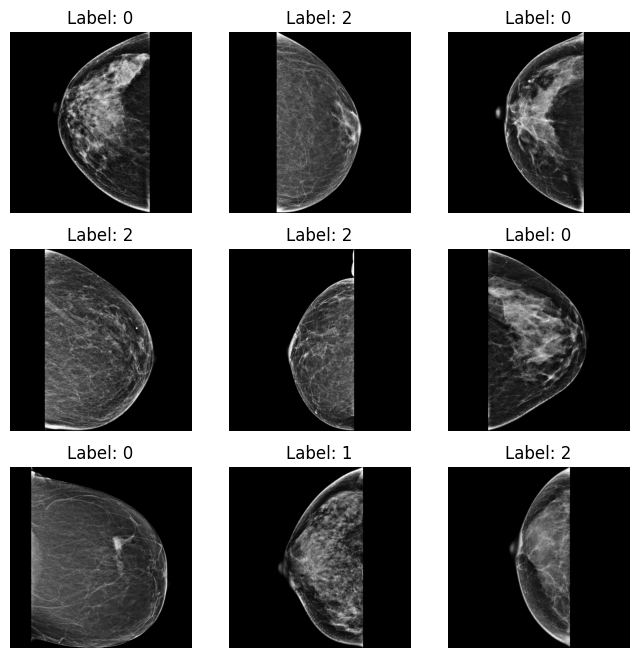

In [29]:
# Function to visualize a batch of images
def show_images_from_dataset(dataset, num_images=9):
    # Take a batch of images and labels
    for images, labels in dataset.take(1):  # Take one batch
        images = images.numpy()  # Convert Tensor to NumPy array
        labels = labels.numpy()

        # Plot images in a grid
        plt.figure(figsize=(8, 8))
        for i in range(min(num_images, images.shape[0])):
            plt.subplot(3, 3, i + 1)
            plt.imshow(images[i].squeeze(), cmap='gray')  # Squeeze in case of single-channel images
            plt.title(f"Label: {labels[i]}")
            plt.axis("off")
        plt.show()
        break  # Only take one batch

# Display a batch from the training dataset
show_images_from_dataset(train_lcc_dataset)

In [9]:
# Define input layer for 1-channel (grayscale) input
input_layer_lcc = Input(shape=(512, 512, 1))

# Convert 1-channel grayscale image to 3-channel input using a 1x1 Conv layer
x = Conv2D(3, (1, 1), activation='linear')(input_layer_lcc)

# Load EfficientNetB3 without passing input_tensor, setting input_shape instead
base_model_lcc = EfficientNetB3(weights='imagenet', include_top=False, input_shape=(512, 512, 3))

# Apply the grayscale conversion before passing data to EfficientNetB3
x = base_model_lcc(x)

# Freeze base model layers initially
base_model_lcc.trainable = False  

# Add custom layers on top of EfficientNetB3
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Dense(64, activation='relu')(x)
output_lcc = Dense(len(lcc_label_mapping), activation='softmax')(x)

# Define the final model
model_lcc = Model(inputs=input_layer_lcc, outputs=output_lcc)

# Compile the model
model_lcc.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),  # Start with a smaller learning rate
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Train the model
history_lcc = model_lcc.fit(
    train_lcc_dataset,
    validation_data=test_lcc_dataset,
    epochs=50,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
        tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-6)
    ]
)

# Fine-tuning (Unfreeze base model for additional training)
base_model_lcc.trainable = True
model_lcc.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),  # Lower learning rate for fine-tuning
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Train again with fine-tuning
history_finetune = model_lcc.fit(
    train_lcc_dataset,
    validation_data=test_lcc_dataset,
    epochs=20,  # Fewer epochs for fine-tuning
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),
        tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=1, min_lr=1e-7)
    ]
)

Epoch 1/50


2025-02-18 09:29:07.079923: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/efficientnetb3/block1b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2025-02-18 09:29:07.747643: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:606] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2025-02-18 09:29:07.768892: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600
2025-02-18 09:29:08.094992: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f9b3c022d80 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-02-18 09:29:08.095026: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA RTX A5500, Compute Capability 8.6
2025-02-18 09:29:08.095037: I tensorflow/compiler/xla/service/service.cc:176]

843/843 [==============================] - 261s 302ms/step - loss: 0.2643 - accuracy: 0.9519 - val_loss: 4.1348 - val_accuracy: 0.3362 - lr: 1.0000e-04
Epoch 2/50
843/843 [==============================] - 253s 300ms/step - loss: 0.5400 - accuracy: 0.8541 - val_loss: 3.1489 - val_accuracy: 0.3362 - lr: 1.0000e-04
Epoch 3/50
843/843 [==============================] - 254s 301ms/step - loss: 0.7448 - accuracy: 0.7684 - val_loss: 2.9896 - val_accuracy: 0.3362 - lr: 1.0000e-04
Epoch 4/50
843/843 [==============================] - 254s 301ms/step - loss: 0.6332 - accuracy: 0.7794 - val_loss: 3.2843 - val_accuracy: 0.3362 - lr: 1.0000e-04
Epoch 5/50
843/843 [==============================] - 254s 301ms/step - loss: 0.5876 - accuracy: 0.8138 - val_loss: 2.9115 - val_accuracy: 0.3362 - lr: 1.0000e-04
Epoch 6/50
843/843 [==============================] - 253s 301ms/step - loss: 0.5642 - accuracy: 0.8145 - val_loss: 2.9372 - val_accuracy: 0.3362 - lr: 1.0000e-04
Epoch 7/50
843/843 [=============

2025-02-18 10:57:55.412441: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/efficientnetb3/block1b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


843/843 [==============================] - 407s 446ms/step - loss: 0.3383 - accuracy: 0.9139 - val_loss: 3.2752 - val_accuracy: 0.3362 - lr: 1.0000e-05
Epoch 2/20
843/843 [==============================] - 374s 444ms/step - loss: 0.6667 - accuracy: 0.7033 - val_loss: 3.2892 - val_accuracy: 0.3362 - lr: 1.0000e-05
Epoch 3/20
843/843 [==============================] - 375s 445ms/step - loss: 0.6881 - accuracy: 0.7547 - val_loss: 2.3345 - val_accuracy: 0.3362 - lr: 5.0000e-06
Epoch 4/20
843/843 [==============================] - 374s 444ms/step - loss: 0.5231 - accuracy: 0.8482 - val_loss: 1.9126 - val_accuracy: 0.3362 - lr: 5.0000e-06
Epoch 5/20
843/843 [==============================] - 375s 445ms/step - loss: 0.4744 - accuracy: 0.8573 - val_loss: 1.4777 - val_accuracy: 0.3362 - lr: 5.0000e-06
Epoch 6/20
843/843 [==============================] - 374s 444ms/step - loss: 0.4263 - accuracy: 0.8695 - val_loss: 686.9966 - val_accuracy: 0.3406 - lr: 5.0000e-06
Epoch 7/20
843/843 [===========

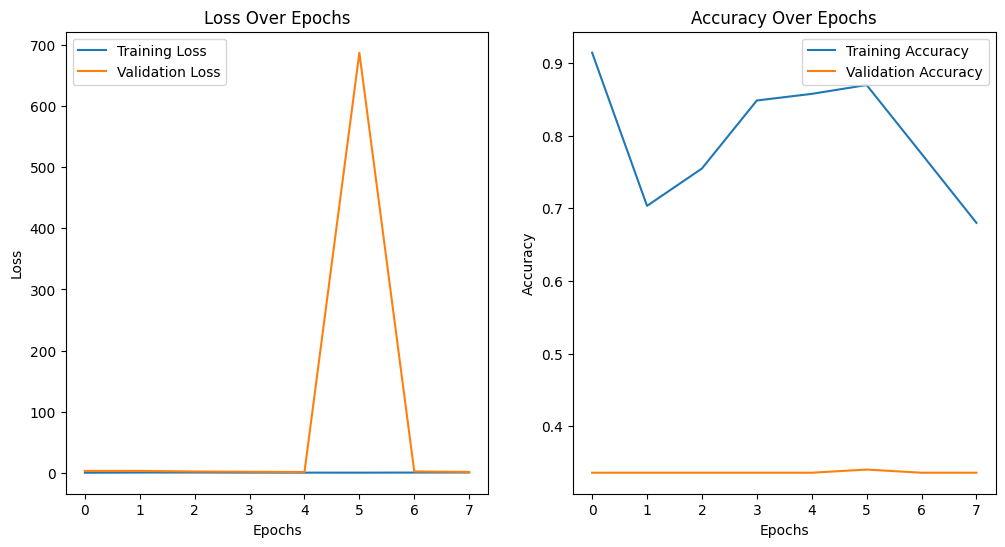

In [10]:
# Plot training and validation loss and accuracy
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 2)
plt.plot(history_finetune.history['accuracy'], label='Training Accuracy')
plt.plot(history_finetune.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy Over Epochs')

plt.subplot(1, 2, 1)
plt.plot(history_finetune.history['loss'], label='Training Loss')
plt.plot(history_finetune.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss Over Epochs')

plt.show()

87/87 [==============================] - 9s 91ms/step


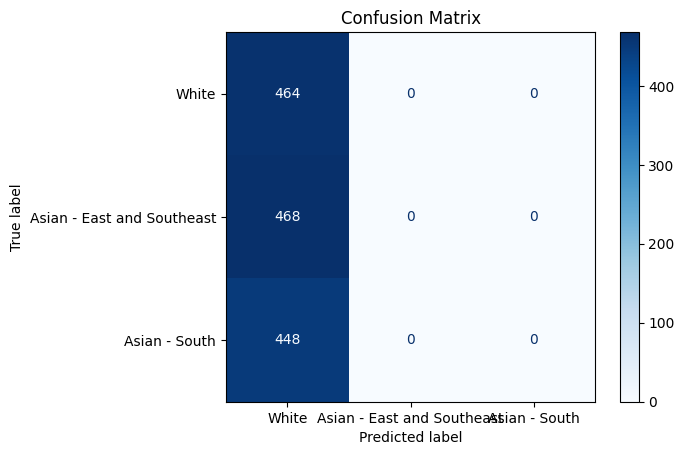

Classification Report:
                            precision    recall  f1-score   support

                     White       0.34      1.00      0.50       464
Asian - East and Southeast       1.00      0.00      0.00       468
             Asian - South       1.00      0.00      0.00       448

                  accuracy                           0.34      1380
                 macro avg       0.78      0.33      0.17      1380
              weighted avg       0.78      0.34      0.17      1380



In [11]:
# Evaluate the model and compute metrics
predictions = model_lcc.predict(test_lcc_dataset)
predicted_labels = tf.argmax(predictions, axis=1).numpy()
true_labels = []
for _, labels in test_lcc_dataset:
    true_labels.extend(labels.numpy())

# Generate confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)
ConfusionMatrixDisplay(conf_matrix, display_labels=list(lcc_label_mapping.keys())).plot(cmap="Blues")
plt.title("Confusion Matrix")
plt.show()

# Generate classification report
print("Classification Report:")
print(classification_report(
    true_labels,
    predicted_labels,
    target_names=list(lcc_label_mapping.keys()),
    zero_division=1  # Sets undefined metrics to 1 instead of raising warnings
))

In [12]:
# Convert confusion matrix to binary format per class
sensitivity = {}
specificity = {}

for i, class_name in enumerate(lcc_label_mapping.keys()):
    # One-vs-all approach
    TP = conf_matrix[i, i]  # True Positives
    FN = np.sum(conf_matrix[i, :]) - TP  # False Negatives
    FP = np.sum(conf_matrix[:, i]) - TP  # False Positives
    TN = np.sum(conf_matrix) - (TP + FP + FN)  # True Negatives

    # Compute sensitivity & specificity
    sensitivity[class_name] = TP / (TP + FN) if (TP + FN) > 0 else 0
    specificity[class_name] = TN / (TN + FP) if (TN + FP) > 0 else 0

# Print results
print("Sensitivity (Recall) per class:")
for class_name, value in sensitivity.items():
    print(f"{class_name}: {value:.4f}")

print("\nSpecificity per class:")
for class_name, value in specificity.items():
    print(f"{class_name}: {value:.4f}")

Sensitivity (Recall) per class:
White: 1.0000
Asian - East and Southeast: 0.0000
Asian - South: 0.0000

Specificity per class:
White: 0.0000
Asian - East and Southeast: 1.0000
Asian - South: 1.0000
